Explore Features with Gradient Tree Boosting
============================================

There are roughly 30 features generated from the data cleaning script. This model will explore feature performance through training and tuning a gradient boosting classifier model.

In [1]:
# set up code and dataframe with training data
import pandas as pd
import numpy as np
import statistics as st

import sklearn.metrics as ms
import sklearn.ensemble as en
import sklearn.model_selection as mds
import matplotlib.pyplot as plt

from scipy import interpolate

datestamp = "20250219.082702"
df_ = pd.read_csv(f"../data/kaggle/train.clean.{datestamp}.csv")
print(df_.shape)

(891, 37)


In [2]:
all_columns = True
#all_columns = False

if all_columns:
    columns_to_drop = [ "Survived", "Name", "Title", "TitleGrouped", "LastName", "Cabin", 
                        "Ticket", "Sex", "Age", "Embarked", "PassengerId" ]
    columns_to_drop += [ "AgeRobust", "FppMinMax", "SibSp", "Parch", "SexOrd" ]
    x_colnames = [i for i in df_.columns if i not in columns_to_drop]
else:
    x_colnames = [ "P3orDeadTitle", "LargeGroup", "FppMinMax", "AgeImputed"  ]

y_colname = [ "Survived" ]

X = df_[ x_colnames ]
y = df_[ y_colname ].values.ravel()

print(X.info())

# Assuming you have your features in X and your target variable in y
X_train, X_test, y_train, y_test = mds.train_test_split(X, y, test_size=0.2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         891 non-null    int64  
 1   Fare           891 non-null    float64
 2   TitleOrd       891 non-null    float64
 3   Master         891 non-null    int64  
 4   Miss           891 non-null    int64  
 5   Mr             891 non-null    int64  
 6   Mrs            891 non-null    int64  
 7   OtherFemale    891 non-null    int64  
 8   OtherMale      891 non-null    int64  
 9   IsMale         891 non-null    int64  
 10  IsChild        891 non-null    int64  
 11  IsYoungChild   891 non-null    int64  
 12  GroupSize      891 non-null    int64  
 13  LargeGroup     891 non-null    int64  
 14  IsAlone        891 non-null    int64  
 15  FarePerPerson  891 non-null    float64
 16  Pclass3        891 non-null    int64  
 17  P3orDeadTitle  891 non-null    int64  
 18  AgeImputed

In [3]:
num_folds = 5
s_scoring = "balanced_accuracy"

param_dist = {
    'learning_rate':     [ 0.7 ],
    'max_features':      [ 3 ],
    'n_estimators':      [ 50 ],
    'max_depth':         [ 7 ],
    'min_samples_split': [ 150 ],
    'min_samples_leaf':  [ 100 ],
    'subsample':         [ 0.7 ],
}

gb_clf = en.GradientBoostingClassifier()
random_search = mds.GridSearchCV( estimator=gb_clf,
                                        param_grid=param_dist,
                                        cv=num_folds,
                                        scoring=s_scoring,
                                        n_jobs=-1 )

random_search.fit(X_train, y_train)
best_params = random_search.best_params_
model = random_search.best_estimator_

print(f"Best Params: {best_params}")

Best Params: {'learning_rate': 0.7, 'max_depth': 7, 'max_features': 3, 'min_samples_leaf': 100, 'min_samples_split': 150, 'n_estimators': 50, 'subsample': 0.7}


In [4]:
importances = model.feature_importances_
feature_imp_df = pd.DataFrame(
    {'Feature': x_colnames, 'Gini Importance': importances} ).sort_values(
         'Gini Importance', ascending=False)
print(feature_imp_df)

          Feature  Gini Importance
9          IsMale         0.340707
20      FppRobust         0.188262
1            Fare         0.081046
2        TitleOrd         0.077313
15  FarePerPerson         0.046711
18     AgeImputed         0.046709
0          Pclass         0.044318
14        IsAlone         0.037650
19      AgeMinMax         0.036898
12      GroupSize         0.035333
16        Pclass3         0.021378
17  P3orDeadTitle         0.020342
4            Miss         0.014877
5              Mr         0.008456
7     OtherFemale         0.000000
8       OtherMale         0.000000
6             Mrs         0.000000
11   IsYoungChild         0.000000
13     LargeGroup         0.000000
3          Master         0.000000
10        IsChild         0.000000


In [5]:
y_train_preds_proba = model.predict_proba(X_train)

train_fpr, train_tpr, train_thresh = ms.roc_curve(y_train, y_train_preds_proba[:,1])
train_roc_auc = ms.auc(train_fpr, train_tpr)

# Calculate the geometric mean
gmeans = np.sqrt(train_tpr * (1 - train_fpr))

# Locate the index of the largest gmean
index = np.argmax(gmeans)
train_threshold = train_thresh[index]

train_tpr_intrp = interpolate.interp1d(train_thresh, train_tpr)
train_fpr_intrp = interpolate.interp1d(train_thresh, train_fpr)

print(f"Train AUC {round(train_roc_auc,3)}")
print(f"Train optimal threshold {round(train_threshold,3)} at " \
      f"tpr: {np.round(train_tpr_intrp(train_threshold),3)}, " \
      f"fpr: {np.round(train_fpr_intrp(train_threshold),3)}")

Train AUC 0.91
Train optimal threshold 0.354 at tpr: 0.813, fpr: 0.139


In [6]:
# calculate test ROC curve
y_test_preds_proba  = model.predict_proba(X_test)

test_fpr, test_tpr, test_thresh = ms.roc_curve(y_test, y_test_preds_proba[:,1])
test_roc_auc = ms.auc(test_fpr, test_tpr)

# Calculate the geometric mean
test_gmeans = np.sqrt(test_tpr * (1 - test_fpr))

# Locate the index of the largest gmean
test_index = np.argmax(test_gmeans)
test_threshold = test_thresh[test_index]

test_tpr_intrp = interpolate.interp1d(test_thresh, test_tpr)
test_fpr_intrp = interpolate.interp1d(test_thresh, test_fpr)

print(f"Test AUC {round(test_roc_auc,3)}")
print(f"Test optimal threshold {round(test_threshold,3)} at " \
      f"tpr: {np.round(test_tpr_intrp(test_threshold),3)}, " \
      f"fpr: {np.round(test_fpr_intrp(test_threshold),3)}")

Test AUC 0.864
Test optimal threshold 0.311 at tpr: 0.813, fpr: 0.173


In [7]:
# Define the desired operating point (FPR, TPR)
test_operating_point_fpr = test_fpr_intrp(test_threshold)
test_operating_point_tpr = test_tpr_intrp(test_threshold)

# Find the closest threshold to the desired operating point
distances = (test_fpr - test_operating_point_fpr)**2 + (test_tpr - test_operating_point_tpr)**2
closest_index = distances.argmin()
test_operating_point_threshold = test_thresh[closest_index]

In [8]:
# Define the desired operating point (FPR, TPR)
train_operating_point_fpr = train_fpr_intrp(train_threshold)
train_operating_point_tpr = train_tpr_intrp(train_threshold)

# Find the closest threshold to the desired operating point
distances = (train_fpr - train_operating_point_fpr)**2 + (train_tpr - train_operating_point_tpr)**2
closest_index = distances.argmin()
train_operating_point_threshold = train_thresh[closest_index]

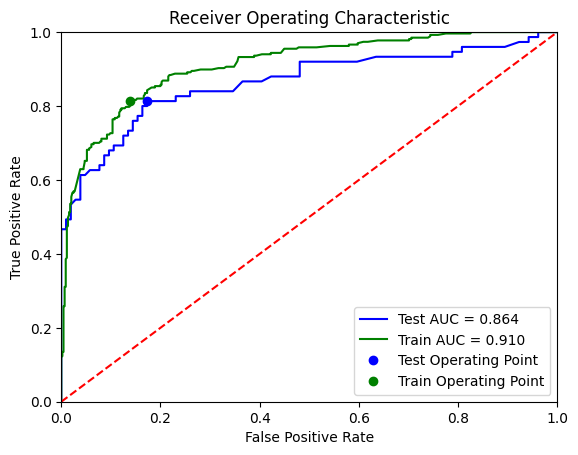

In [9]:
plt.title('Receiver Operating Characteristic')

plt.plot(test_fpr, test_tpr, 'b', label = 'Test AUC = %0.3f' % test_roc_auc)
plt.plot(train_fpr, train_tpr, 'g', label = 'Train AUC = %0.3f' % train_roc_auc)
plt.plot([0, 1], [0, 1],'r--')

plt.plot(test_operating_point_fpr,test_operating_point_tpr, 'bo', label=f'Test Operating Point')
plt.plot(train_operating_point_fpr,train_operating_point_tpr, 'go', label=f'Train Operating Point')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc = 'lower right')
plt.show()

In [10]:
test_threshold = 0.65

y_test_preds = (y_test_preds_proba[:,1] > test_threshold).astype(int)

tn, fp, fn, tp = ms.confusion_matrix(y_test, y_test_preds).ravel()
print(f"Confusion Matrix, at Threshold {test_threshold:.3f}")
print(f"  tn {tn:<3}  fp {fp:<3}")
print(f"  fn {fn:<3}  tp {tp:<3}")
print()

bal_acc   = round( ms.balanced_accuracy_score( y_test, y_test_preds ), 3 )
precision = round( ms.precision_score( y_test, y_test_preds ), 3 )
recall    = round( ms.recall_score( y_test, y_test_preds ), 3 )
f1        = round( ms.f1_score( y_test, y_test_preds, average='micro' ), 3 )

s_scores = f"Bal Acc: {bal_acc}, Pre: {precision}, Rec: {recall}, F1 Micro: {f1}"
print(s_scores)

Confusion Matrix, at Threshold 0.650
  tn 102  fp 2  
  fn 35   tp 40 

Bal Acc: 0.757, Pre: 0.952, Rec: 0.533, F1 Micro: 0.793


In [11]:
df_test = pd.read_csv(f"../data/kaggle/test.clean.{datestamp}.csv")

y_proba = model.predict_proba(df_test[x_colnames])
y_preds = (y_proba[:,1] > test_threshold).astype(int)

df_test["SurvivedProbability"] = y_proba[:,1]
df_test["Survived"] = y_preds

df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,FarePerPerson,Pclass3,P3orDeadTitle,AgeImputed,AgeRobust,AgeMinMax,FppRobust,FppMinMax,SurvivedProbability,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,...,7.8292,1,1,34.5,0.5312,0.4300,-0.0377,0.0153,0.124344,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,...,3.5000,1,1,47.0,1.3125,0.5866,-0.2970,0.0068,0.186419,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,...,9.6875,0,1,62.0,2.2500,0.7745,0.0736,0.0189,0.039506,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,...,8.6625,1,1,27.0,0.0625,0.3361,0.0122,0.0169,0.062431,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,...,4.0958,1,1,22.0,-0.2500,0.2735,-0.2613,0.0080,0.478527,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,...,8.0500,1,1,25.6,-0.0250,0.3186,-0.0245,0.0157,0.083238,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,...,108.9000,0,0,39.0,0.8125,0.4864,6.0155,0.2126,0.930341,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,...,7.2500,1,1,38.5,0.7812,0.4801,-0.0724,0.0142,0.031947,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,...,8.0500,1,1,25.6,-0.0250,0.3186,-0.0245,0.0157,0.083238,0


## Write Output to File

In [12]:
#df_test[["PassengerId", "Survived"]].to_csv(f"../data/kaggle/submit.boosting.csv", index=False)